# **Librerías y carga de datos**
En esta sección se importan todas las libreríaas que son necesarias para la limpieza y transformación de los datos.

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import requests
from io import StringIO

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Gestión de librerías
# ==============================================================================
from importlib import reload


# Preparación de datos
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import joblib

# Modelos
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from geopy.distance import great_circle
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from branca.element import Template, MacroElement

# Conexion Drive
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

encoder = joblib.load('/content/drive/MyDrive/Monografia Especializacion/Models/label_encoders.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Modelo con no normalizados**


In [ ]:
# Importar datos
# ==============================================================================
df = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_decod.csv')
df.info()
#df = df.sample(n=30000, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492988 entries, 0 to 492987
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   latitud         492988 non-null  float64
 1   longitud        492988 non-null  float64
 2   sexo            492988 non-null  int64  
 3   edad            492988 non-null  int64  
 4   estado_civil    492988 non-null  int64  
 5   conducta        492988 non-null  int64  
 6   modalidad       492988 non-null  int64  
 7   arma_medio      492988 non-null  int64  
 8   codigo_comuna   492988 non-null  int64  
 9   lugar           492988 non-null  int64  
 10  categoria_bien  492988 non-null  int64  
 11  día             492988 non-null  int64  
 12  mes             492988 non-null  int64  
 13  zona            492988 non-null  int64  
 14  rango_hora      492988 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 56.4 MB


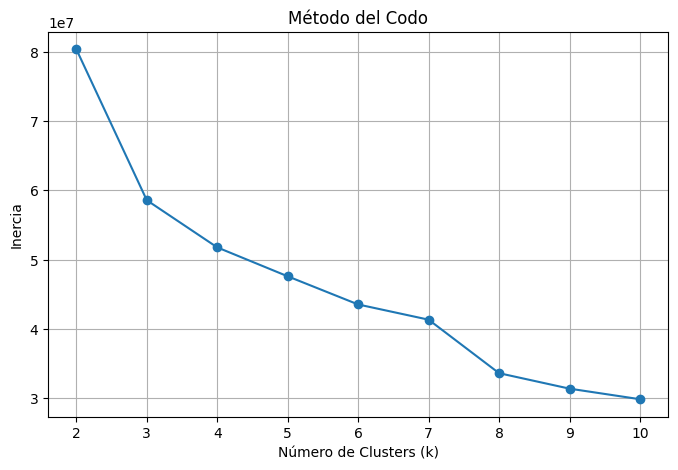

In [ ]:
# Metodo codo para identificar cantidad de clusters
# ==============================================================================

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    kmeans.fit(df.drop(columns=['latitud', 'longitud']))
    inertia.append(kmeans.inertia_)

# Graficar método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

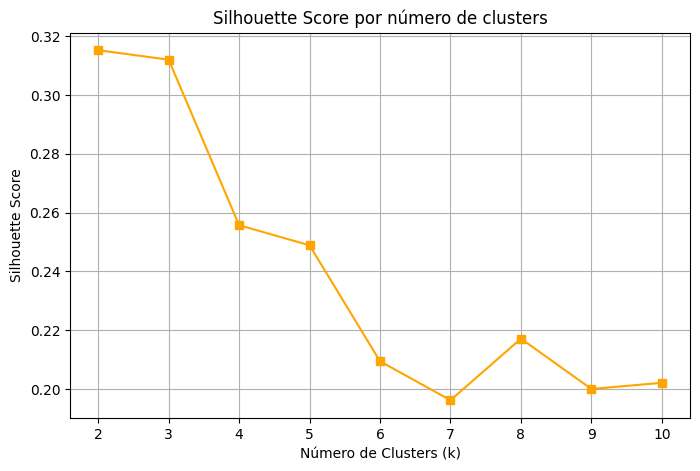

In [ ]:
# silhouette scores
# ==============================================================================
df_sample = df.sample(n=25000, random_state=42)
silhouette_scores = []
for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=500)
    labels = kmeans.fit_predict(df_sample.drop(columns=['latitud', 'longitud']))
    silhouette_scores.append(silhouette_score(df_sample, labels))

# Graficar silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='s', color='orange')
plt.title('Silhouette Score por número de clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
# Modelado
# ==============================================================================

# Kluster
k_optimo = 3
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42)
df['cluster'] = kmeans_final.fit_predict(df.drop(columns=['latitud', 'longitud']))

# Análisis de los clusters
cluster_summary = df.groupby('cluster').mean()

print("Resumen por cluster:")
print(cluster_summary)


Resumen por cluster:
          latitud   longitud      sexo       edad  estado_civil  conducta  \
cluster                                                                     
0        6.248873 -75.575898  0.365108  29.348043      0.680207   2.51610   
1        6.248728 -75.573911  0.365176  29.362286      0.679173   2.51894   
2        6.247893 -75.576958  0.388927  50.239104      0.444429   2.57111   

         modalidad  arma_medio  codigo_comuna     lugar  categoria_bien  \
cluster                                                                   
0         0.492688    0.502134      10.494681  0.457840        0.509939   
1         0.499193    0.498570      10.525409  0.459987        0.512578   
2         0.448675    0.528080      10.745699  0.491423        0.441764   

               día       mes      zona  rango_hora  
cluster                                             
0         7.784783  6.713450  1.058431    1.632717  
1        23.388821  6.710563  1.056493    1.640020  
2    

In [ ]:
# visualizacion
# ==============================================================================

df_sample = df.sample(n=50000, random_state=42)
df_dots = df_sample[["latitud", "longitud", "cluster"]]

#df_dots[["latitud", "longitud"]]  = scaler.inverse_transform(df_dots[["latitud", "longitud"]])

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('tab20', num_clusters)

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=1.5,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.5
    ).add_to(mapa)

# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)

mapa





Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Volver a valores originales para analisis
# ==============================================================================
var = df.columns.to_list()
var.remove('cluster')
cluster_summary = df.groupby('cluster').agg(lambda x: x.mode().iloc[0])

cluster_summary_decoded = cluster_summary.copy()
for col in cluster_summary_decoded.columns:
    if col in encoder:
        cluster_summary_decoded[col] = cluster_summary_decoded[col].round().astype(int)
        cluster_summary_decoded[col] = encoder[col].inverse_transform(cluster_summary_decoded[col])

cluster_summary_decoded['Cantidad'] = df.groupby('cluster').size()
var.append('Cantidad')
cluster_summary_decoded[var].reset_index()


,cluster,latitud,longitud,sexo,edad,estado_civil,conducta,modalidad,arma_medio,codigo_comuna,lugar,categoria_bien,día,mes,zona,rango_hora,Cantidad
0,0,6.213286,-75.576136,Hombre,32,soltero,Hurto a persona,no_violentos,Sin_arma,10,exteriores,alto_valor,1,8,Centro,Noche,188103
1,1,6.249775,-75.568542,Hombre,32,soltero,Hurto a persona,no_violentos,Con_Arma,10,exteriores,alto_valor,28,10,Centro,Noche,187827
2,2,6.249775,-75.568542,Hombre,58,en_relacion,Hurto a persona,no_violentos,Sin_arma,10,exteriores,alto_valor,15,11,Centro,Tarde,117058


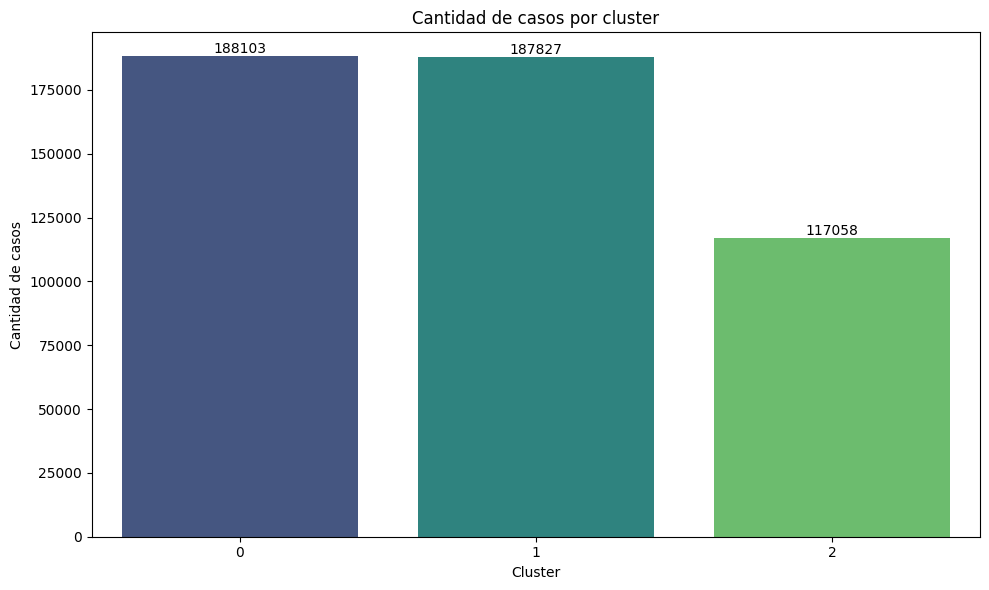

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_summary_decoded,
    x='cluster',
    y='Cantidad',
    palette='viridis'
)

# Agregar etiquetas de texto encima de las barras
for index, row in cluster_summary_decoded.reset_index().iterrows():
    plt.text(row['cluster'], row['Cantidad'] + 100, str(row['Cantidad']), ha='center', va='bottom')

# Etiquetas
plt.title("Cantidad de casos por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# **Modelo con normalizados**


In [ ]:
df_norm = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_normalize.csv')
scaler = joblib.load('/content/drive/MyDrive/Monografia Especializacion/Models/standard_scaler.pkl')
df_norm.info()
#df_norm = df_norm.sample(n=25000, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492988 entries, 0 to 492987
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   latitud         492988 non-null  float64
 1   longitud        492988 non-null  float64
 2   sexo            492988 non-null  float64
 3   edad            492988 non-null  float64
 4   estado_civil    492988 non-null  float64
 5   conducta        492988 non-null  float64
 6   modalidad       492988 non-null  float64
 7   arma_medio      492988 non-null  float64
 8   codigo_comuna   492988 non-null  float64
 9   lugar           492988 non-null  float64
 10  categoria_bien  492988 non-null  float64
 11  día             492988 non-null  float64
 12  mes             492988 non-null  float64
 13  zona            492988 non-null  float64
 14  rango_hora      492988 non-null  float64
dtypes: float64(15)
memory usage: 56.4 MB


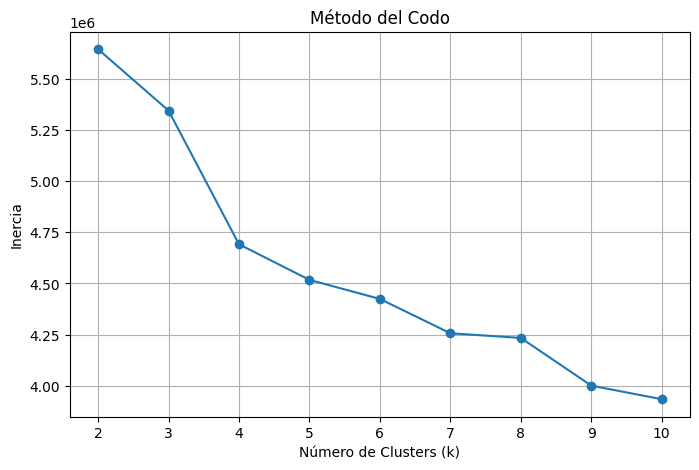

In [ ]:
# Metodo codo para identificar cantidad de clusters
# ==============================================================================

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    kmeans.fit(df_norm.drop(columns=['latitud', 'longitud']))
    inertia.append(kmeans.inertia_)

# 4. Graficar método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

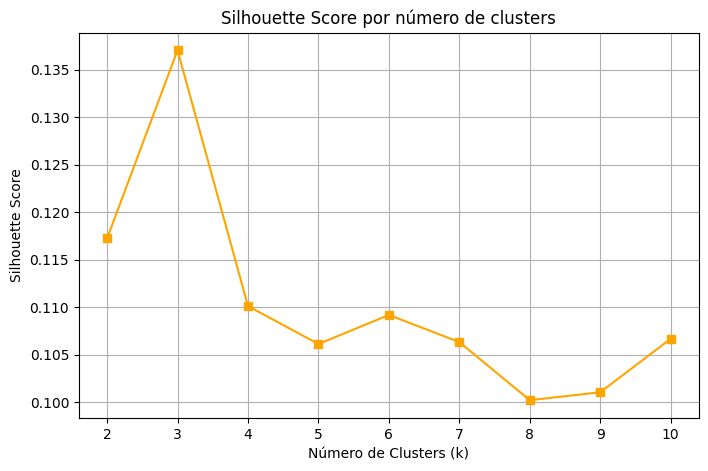

In [ ]:
# silhouette scores
# ==============================================================================
df_norm_sample = df_norm.sample(n=25000, random_state=42)
silhouette_scores = []
for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    labels = kmeans.fit_predict(df_norm_sample.drop(columns=['latitud', 'longitud']))
    silhouette_scores.append(silhouette_score(df_norm_sample, labels))

# 6. Graficar silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='s', color='orange')
plt.title('Silhouette Score por número de clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
# Modelado
# ==============================================================================


# Kluster
k_optimo = 3
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42)
columns = df_norm.columns
df_norm['cluster'] = kmeans_final.fit_predict(df_norm.drop(columns=['latitud', 'longitud']))

# Análisis de los clusters
cluster_summary = df_norm.groupby('cluster').mean()

print("Resumen por cluster:")
print(cluster_summary)


Resumen por cluster:
          latitud  longitud      sexo      edad  estado_civil  conducta  \
cluster                                                                   
0       -0.116848 -0.003998  0.201896  0.119964      0.003860 -0.440485   
1        0.006351  0.004152  0.004170 -0.060383      0.035196 -0.485492   
2        0.211886 -0.000221 -0.394865 -0.115254     -0.074233  1.766142   

         modalidad  arma_medio  codigo_comuna     lugar  categoria_bien  \
cluster                                                                   
0        -0.827214    0.698365       0.067750  0.579148       -0.433928   
1         0.929648   -0.754016       0.002219 -0.389960       -0.509487   
2        -0.179948    0.093377      -0.134062 -0.369458        1.799141   

              día       mes      zona  rango_hora  
cluster                                            
0       -0.006780  0.033494 -0.004612   -0.040662  
1        0.004601  0.000381  0.022670    0.061636  
2        0.004258 -

In [ ]:
# visualizacion
# ==============================================================================


df_dots = df_norm.sample(n=50000, random_state=42)

df_dots[columns]  = scaler.inverse_transform(df_dots[columns])

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('tab20', num_clusters)

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=1.5,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.5
    ).add_to(mapa)

# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)


mapa




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
var = df_norm.columns.to_list()
var.remove('cluster')

df_norm[var]  = scaler.inverse_transform(df_norm[var])

cluster_summary = df_norm.groupby('cluster').agg(lambda x: x.mode().iloc[0])

cluster_summary_decoded = cluster_summary.copy()
for col in cluster_summary_decoded.columns:
    if col in encoder:
        cluster_summary_decoded[col] = cluster_summary_decoded[col].round().astype(int)
        cluster_summary_decoded[col] = encoder[col].inverse_transform(cluster_summary_decoded[col])

cluster_summary_decoded['Cantidad'] = df_norm.groupby('cluster').size()
var.append('Cantidad')
cluster_summary_decoded[var].reset_index()

,cluster,latitud,longitud,sexo,edad,estado_civil,conducta,modalidad,arma_medio,codigo_comuna,lugar,categoria_bien,día,mes,zona,rango_hora,Cantidad
0,0,6.247223,-75.567321,Hombre,32.0,soltero,Hurto a persona,no_violentos,Sin_arma,10.0,interiores,alto_valor,2.0,8.0,Centro,Tarde,196208
1,1,6.249775,-75.568542,Hombre,32.0,soltero,Hurto a persona,violentos,Con_Arma,10.0,exteriores,alto_valor,5.0,10.0,Centro,Noche,194405
2,2,6.273442,-75.592913,Hombre,32.0,soltero,Hurto de moto,no_violentos,Sin_arma,10.0,exteriores,vehiculos,19.0,5.0,Centro,Noche,102375


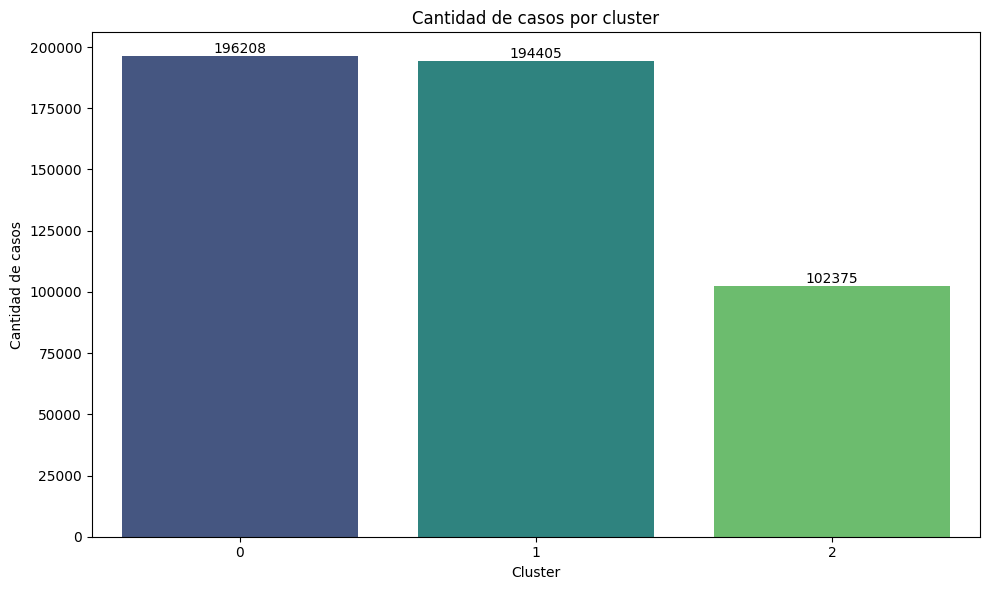

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_summary_decoded,
    x='cluster',
    y='Cantidad',
    palette='viridis'
)

# Agregar etiquetas de texto encima de las barras
for index, row in cluster_summary_decoded.reset_index().iterrows():
    plt.text(row['cluster'], row['Cantidad'] + 100, str(row['Cantidad']), ha='center', va='bottom')

# Etiquetas
plt.title("Cantidad de casos por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# **Reduccion de dimensionalidad**

In [ ]:
df_reduc = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_normalize.csv')
df_reduc = df_reduc.sample(n=10000, random_state=42)

In [ ]:
# Kernel pca - identificacion de componentes optimos
# ==============================================================================

k_range = range(2, 7)
X = df_reduc.values
X_DF = pd.DataFrame(data = np.array(df_reduc.drop(columns=['latitud', 'longitud']).values))

def error_kernelpca(datos_OR, datos_Reconstruidos):
  perdida = np.sum((np.array(datos_OR) - np.array(datos_Reconstruidos))**2, axis = 1)
  perdida = pd.Series(data = perdida, index = datos_OR.index)
  perdida = (perdida - np.min(perdida))/(np.max(perdida) - np.min(perdida))
  return perdida

result = []

for i in k_range:
  kernel_pca = KernelPCA(
      n_components=i, kernel="rbf", gamma=0.1, fit_inverse_transform=True
  )
  print(i)
  X_test_kernel_pca = kernel_pca.fit_transform(df_reduc.drop(columns=['latitud', 'longitud']).values)
  X_inverse = kernel_pca.inverse_transform(X_test_kernel_pca)
  x_inverse = pd.DataFrame(data = np.array(X_inverse))
  result.append(f'Error con {i} componentes: {np.mean(error_kernelpca(X_DF, X_inverse))}')




In [ ]:
for i in result:
  print(i)

Error con 2 componentes: 0.03555383720467098
Error con 3 componentes: 0.03292660901734188
Error con 4 componentes: 0.029572320735391747
Error con 5 componentes: 0.02661255167570821
Error con 6 componentes: 0.02384377668043623


In [ ]:
# Kernel pca
# ==============================================================================


kernel_pca = KernelPCA(
    n_components=5, kernel="rbf", gamma=0.1
)
X_test_kernel_pca = kernel_pca.fit_transform(X)

# Crear DataFrame de los componentes reducidos
df_kernel_pca = pd.DataFrame(
    X_test_kernel_pca,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
    index=df_reduc.iloc[X_test_kernel_pca.shape[0]*-1:].index
)

# Crear DataFrame original de test
df_test_original = pd.DataFrame(X, columns=df_reduc.columns)

# Concatenar
df_combined = pd.concat([df_test_original.reset_index(drop=True), df_kernel_pca.reset_index(drop=True)], axis=1)

df_combined.head()



,latitud,longitud,sexo,edad,estado_civil,conducta,modalidad,arma_medio,codigo_comuna,lugar,categoria_bien,día,mes,zona,rango_hora,PC1,PC2,PC3,PC4,PC5
0,1.136700,0.005946,1.302668,-0.215400,0.776534,-1.263604,1.031051,-1.013972,-1.005474,1.069119,0.613005,-1.083053,0.374026,-0.545270,-0.599263,0.111223,-0.096248,-0.034838,0.158547,0.132632
1,1.524584,0.008360,1.302668,0.063861,0.776534,-0.437851,1.031051,-1.013972,-0.824828,-0.935349,-0.600282,1.636618,-1.650185,1.512197,-1.527258,0.089186,0.050357,0.028643,0.160094,0.168741
2,-0.580780,0.103102,-0.767655,0.436207,-1.287774,1.213655,-0.969885,0.986220,-0.282890,-0.935349,1.826292,-1.083053,-0.782666,-0.545270,0.328733,-0.181407,0.374321,0.005134,-0.105530,-0.159018
3,-1.109915,0.013558,1.302668,-0.215400,-1.287774,-1.263604,1.031051,-1.013972,0.620340,1.069119,0.613005,-1.309693,0.663199,-0.545270,-0.599263,0.044181,-0.063687,0.203178,0.122674,0.117824
4,0.035527,0.064806,-0.767655,-0.122313,-1.287774,1.213655,-0.969885,0.986220,-0.463536,1.069119,1.826292,-1.536332,-0.204320,-0.545270,-1.527258,-0.223359,0.253834,0.005975,-0.122659,0.072195


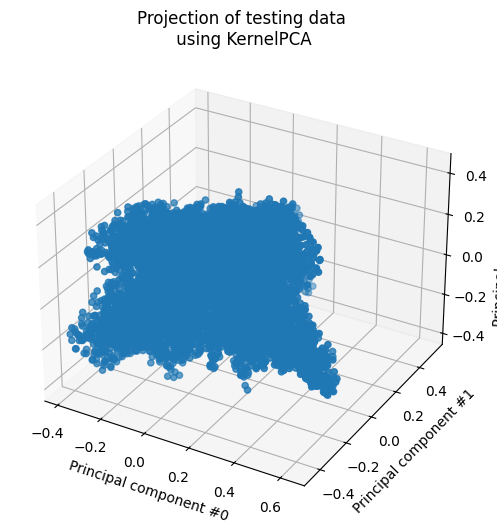

In [ ]:
fig = plt.figure(figsize=(10, 6))
kernel_pca_proj_ax = fig.add_subplot(111, projection='3d')  # Activa el modo 3D

# Grafica en 3D usando los tres primeros componentes principales
kernel_pca_proj_ax.scatter(
    X_test_kernel_pca[:, 0],
    X_test_kernel_pca[:, 1],
    X_test_kernel_pca[:, 2],
    cmap="viridis"
)

# Etiquetas de los ejes
kernel_pca_proj_ax.set_xlabel("Principal component #0")
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_zlabel("Principal component #2")
kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")

plt.show()

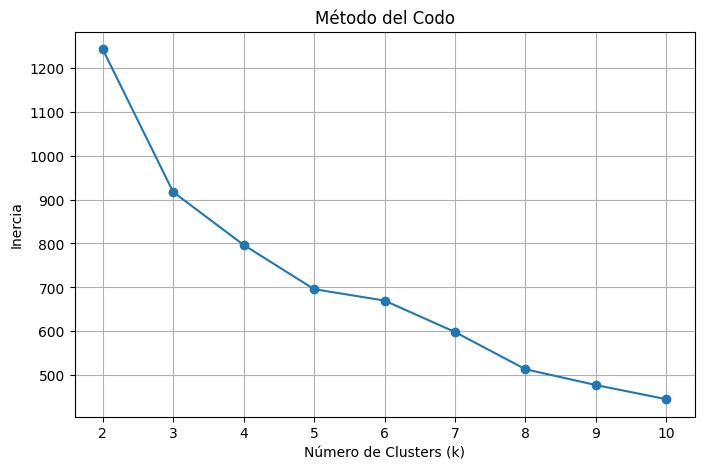

In [ ]:
# Metodo codo para identificar cantidad de clusters
# ==============================================================================

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_test_kernel_pca)
    inertia.append(kmeans.inertia_)

# 4. Graficar método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

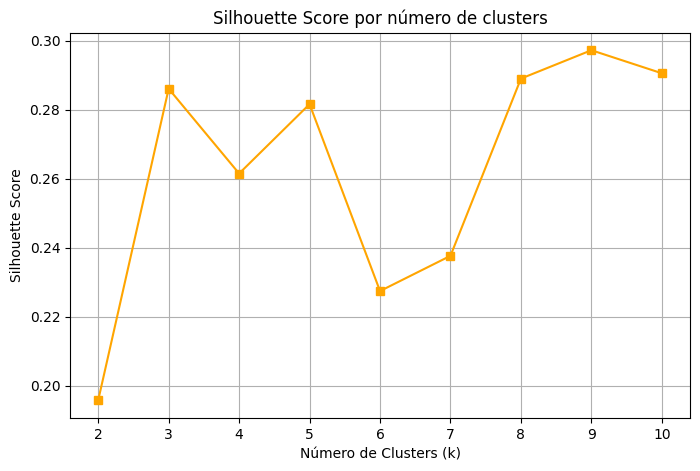

In [ ]:
# silhouette scores
# ==============================================================================
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_test_kernel_pca)
    silhouette_scores.append(silhouette_score(X_test_kernel_pca, labels))

# 6. Graficar silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='s', color='orange')
plt.title('Silhouette Score por número de clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
# Modelado
# ==============================================================================

df_kernel = pd.DataFrame(X_test_kernel_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
# Kluster
k_optimo = 8
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42)
columns = df_kernel.columns
df_combined['cluster'] = kmeans_final.fit_predict(df_kernel)

# Análisis de los clusters
cluster_summary = df_combined.groupby('cluster').mean()

print("Resumen por cluster:")
print(cluster_summary)


Resumen por cluster:
          latitud  longitud      sexo      edad  estado_civil  conducta  \
cluster                                                                   
0       -0.251750  0.000154  0.029603  0.180187     -0.038176 -0.406786   
1       -0.144998 -0.000582  1.294565 -0.311037      0.705838 -0.454010   
2       -0.118589 -0.003443  0.110358  0.680463     -1.054893 -0.425200   
3        0.100901  0.000534 -0.449814  0.551905     -1.146681 -0.482134   
4        0.226930 -0.001886 -0.376626 -0.126969     -0.059226  1.768018   
5       -0.052913 -0.003539 -0.767655 -0.390745      0.749150 -0.511157   
6        0.072990 -0.001481 -0.767655 -0.533863      0.772770 -0.499575   
7       -0.001857 -0.004378  1.270922 -0.335913      0.455469 -0.484882   

         modalidad  arma_medio  codigo_comuna     lugar  categoria_bien  \
cluster                                                                   
0         0.294728   -0.395582       0.446984  0.291736       -0.360446   
1  

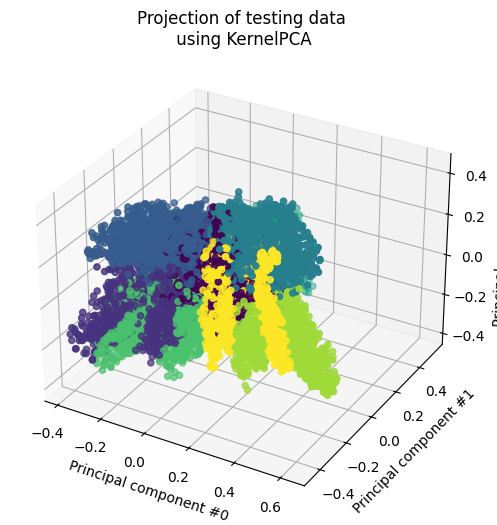

In [ ]:
fig = plt.figure(figsize=(10, 6))
kernel_pca_proj_ax = fig.add_subplot(111, projection='3d')  # Activa el modo 3D

# Grafica en 3D usando los tres primeros componentes principales
kernel_pca_proj_ax.scatter(
    df_combined['PC1'],
    df_combined['PC2'],
    df_combined['PC3'],
    c = df_combined['cluster'],
    cmap="viridis"
)

# Etiquetas de los ejes
kernel_pca_proj_ax.set_xlabel("Principal component #0")
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_zlabel("Principal component #2")
kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")

plt.show()

In [ ]:
# visualizacion
# ==============================================================================

df_dots = df_combined.copy()
df_dots.drop(columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], inplace=True)
columns = [col for col in df_dots.columns if col != 'cluster']

df_dots[columns]  = scaler.inverse_transform(df_dots[columns])

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('tab10', num_clusters)

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=1.5,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.5
    ).add_to(mapa)


# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)


mapa




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
var = df_combined.columns.to_list()
var.remove('cluster')
var.remove('PC1')
var.remove('PC2')
var.remove('PC3')
var.remove('PC4')
var.remove('PC5')
df_combined[var]  = scaler.inverse_transform(df_combined[var])

cluster_summary = df_combined.groupby('cluster').agg(lambda x: x.mode().iloc[0])

cluster_summary_decoded = cluster_summary.copy()
for col in cluster_summary_decoded.columns:
    if col in encoder:
        cluster_summary_decoded[col] = cluster_summary_decoded[col].round().astype(int)
        cluster_summary_decoded[col] = encoder[col].inverse_transform(cluster_summary_decoded[col])

cluster_summary_decoded['Cantidad'] = df_combined.groupby('cluster').size()
var.append('Cantidad')
cluster_summary_decoded[var].reset_index()

,cluster,latitud,longitud,sexo,edad,estado_civil,conducta,modalidad,arma_medio,codigo_comuna,lugar,categoria_bien,día,mes,zona,rango_hora,Cantidad
0,0,6.199036,-75.573604,Hombre,32.0,soltero,Hurto a persona,violentos,Con_Arma,10.0,interiores,alto_valor,27.0,1.0,Centro,Madrugada,1462
1,1,6.191910,-75.605376,Mujer,32.0,soltero,Hurto a persona,no_violentos,Sin_arma,10.0,interiores,alto_valor,28.0,8.0,Centro,Mañana,1022
2,2,6.217438,-75.602586,Hombre,32.0,en_relacion,Hurto a persona,no_violentos,Sin_arma,10.0,interiores,alto_valor,2.0,8.0,Centro,Tarde,1436
3,3,6.239712,-75.589298,Hombre,32.0,en_relacion,Hurto a persona,violentos,Con_Arma,10.0,exteriores,alto_valor,5.0,5.0,Centro,Tarde,951
4,4,6.265365,-75.571506,Hombre,32.0,soltero,Hurto de moto,no_violentos,Sin_arma,10.0,exteriores,vehiculos,18.0,10.0,Centro,Noche,2139
5,5,6.225917,-75.606081,Hombre,32.0,soltero,Hurto a persona,no_violentos,Sin_arma,10.0,interiores,alto_valor,13.0,9.0,Centro,Noche,980
6,6,6.249775,-75.568542,Hombre,32.0,soltero,Hurto a persona,violentos,Con_Arma,10.0,exteriores,alto_valor,9.0,8.0,Centro,Noche,1097
7,7,6.182872,-75.662376,Mujer,32.0,soltero,Hurto a persona,violentos,Con_Arma,10.0,exteriores,alto_valor,17.0,11.0,Centro,Tarde,913


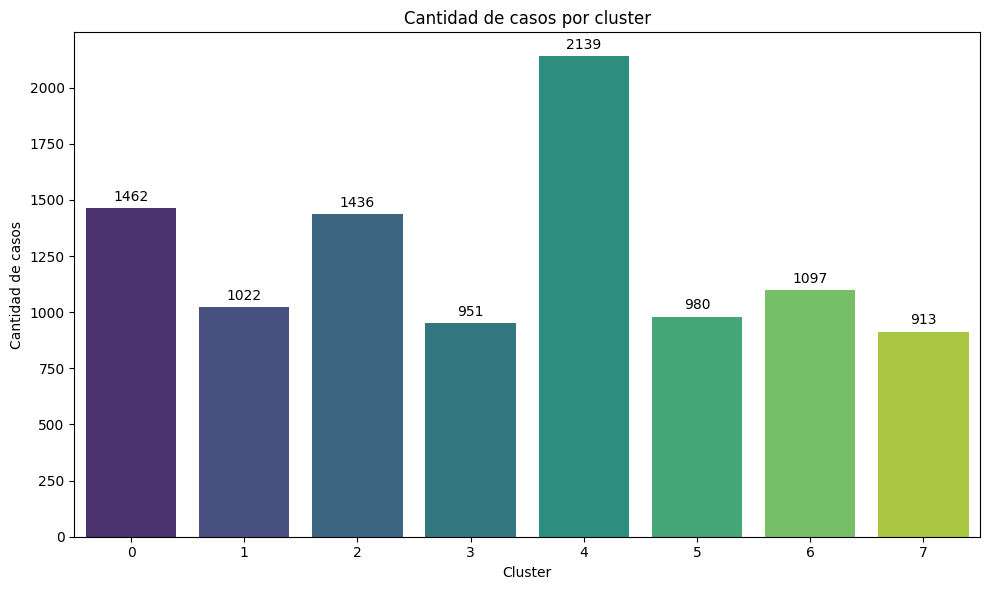

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_summary_decoded,
    x='cluster',
    y='Cantidad',
    palette='viridis'
)

# Agregar etiquetas de texto encima de las barras
for index, row in cluster_summary_decoded.reset_index().iterrows():
    plt.text(row['cluster'], row['Cantidad'] + 20, str(row['Cantidad']), ha='center', va='bottom')

# Etiquetas
plt.title("Cantidad de casos por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()